{'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}
{'A30': 0, 'A31': 1, 'A32': 2, 'A33': 3, 'A34': 4}
{'A40': 0, 'A41': 1, 'A410': 2, 'A42': 3, 'A43': 4, 'A44': 5, 'A45': 6, 'A46': 7, 'A48': 8, 'A49': 9}
{'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}
{'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}
{'A91': 0, 'A92': 1, 'A93': 2, 'A94': 3}
{'A101': 0, 'A102': 1, 'A103': 2}
{'A121': 0, 'A122': 1, 'A123': 2, 'A124': 3}
{'A141': 0, 'A142': 1, 'A143': 2}
{'A151': 0, 'A152': 1, 'A153': 2}
{'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}
{'A191': 0, 'A192': 1}
{'A201': 0, 'A202': 1}
{1: 0, 2: 1}


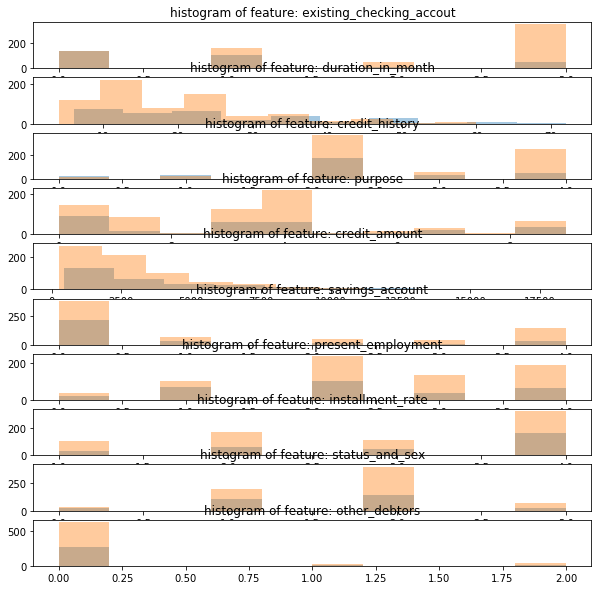

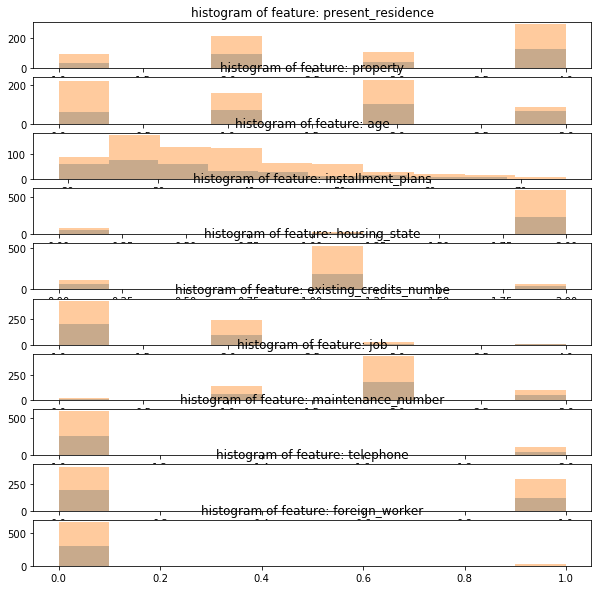

In [2]:
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import gc
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
data = pd.read_csv("german.data",sep=' ',header=None)
feature = ["existing_checking_accout","duration_in_month","credit_history","purpose","credit_amount",
            "savings_account","present_employment","installment_rate","status_and_sex","other_debtors",
            "present_residence","property","age","installment_plans","housing_state",
            "existing_credits_numbe","job","maintenance_number","telephone","foreign_worker","default"]
data.columns = feature

# 非连续型特征
qualitative = ["existing_checking_accout","credit_history","purpose",
                "savings_account","present_employment","status_and_sex","other_debtors",
                "property","installment_plans","housing_state",
                "job","telephone","foreign_worker","default"]
# 各特征的直方图
da = data
for i in range(len(qualitative)):
    class_mapping = {label:idx for idx, label in enumerate(np.unique(da[qualitative[i]]))}
    print(class_mapping)
    da[qualitative[i]] = da[qualitative[i]].map(class_mapping)
v_feat = da.columns[0:10]
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(10, 1)
for i, cn in enumerate(data[v_feat]):
    ax = plt.subplot(gs[i])
    sns.distplot(da[da["default"] == 1][cn], bins=10, kde=False, label='Class_1')
    sns.distplot(da[da["default"] == 0][cn], bins=10, kde=False, label='Class_0')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

v_feat = da.columns[10:20]
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(10, 1)
for i, cn in enumerate(data[v_feat]):
    ax = plt.subplot(gs[i])
    sns.distplot(da[da["default"] == 1][cn], bins=10, kde=False, label='Class_1')
    sns.distplot(da[da["default"] == 0][cn], bins=10, kde=False, label='Class_0')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

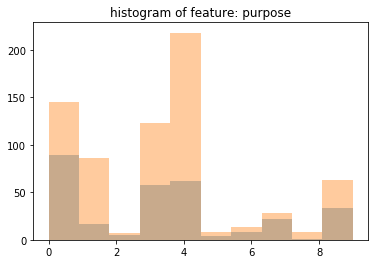

In [4]:
v_feat = da.columns[3:4]
plt.figure()
gs = gridspec.GridSpec(1, 1)
for i, cn in enumerate(data[v_feat]):
    ax = plt.subplot(gs[i])
    sns.distplot(da[da["default"] == 1][cn], bins=10, kde=False, label='Class_1')
    sns.distplot(da[da["default"] == 0][cn], bins=10, kde=False, label='Class_0')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()
# 'A40': 0, 'A41': 1, 'A410': 2, 'A42': 3, 'A43': 4, 'A44': 5, 'A45': 6, 'A46': 7, 'A48': 8, 'A49': 9
#  A48 retraining > A41 car(used) > A43 radio/television > A42 furniture/equipment >A44 domestic appliances > A49 business > 
#  A45 repairs > A40 car(new) > A46 education > A410 other

In [11]:
data = pd.read_csv("german.data",sep=' ',header=None)
feature = ["existing_checking_accout","duration_in_month","credit_history","purpose","credit_amount",
            "savings_account","present_employment","installment_rate","status_and_sex","other_debtors",
            "present_residence","property","age","installment_plans","housing_state",
            "existing_credits_numbe","job","maintenance_number","telephone","foreign_worker","default"]
data.columns = feature
qualitative_feature = ["existing_checking_accout","credit_history","savings_account","present_employment","other_debtors",
                       "installment_plans","job","telephone","foreign_worker","default"]
# car(used)> radio/television > furniture/equipment > business > car (new)...
purpose_mapping = {'A41': 10, 'A43':9,'A42': 8, 'A49':7, 'A40':6,
                'A44':5, 'A45':4, 'A46':3, 'A47':2, 'A48':1, 'A410':0}
data['purpose'] = data['purpose'].map(purpose_mapping)
# 5:divorced/separated M 4:divorced/separated/married F 3:single M 2:single F 1:married/widowed M
sex_mapping = {'A91':0, 'A92':1, 'A93':2, 'A95':3, 'A94':4} 
data['status_and_sex'] = data['status_and_sex'].map(sex_mapping)
property_mapping = {'A121': 3, 'A123': 2,'A122': 1, 'A124':0} #Property 3:real estate  2: car or other 1:savings agreement/life insurance 0:none
data['property'] = data['property'].map(property_mapping)
housing_mapping = {'A152': 2, 'A151': 1,'A153': 0}  #housing 3:own 1:rent 1:for free
data['housing_state'] = data['housing_state'].map(housing_mapping)

for i in range(len(qualitative_feature)):
    class_mapping = {label:idx for idx, label in enumerate(np.unique(data[qualitative_feature[i]]))}
    print(class_mapping)
    data[qualitative_feature[i]] = data[qualitative_feature[i]].map(class_mapping)
data.info()

# feature engineering 特征相乘相除
b=feature[:20]  # 前20个
data_temp=data[b]
df_feature=pd.DataFrame()
n=len(b)
for i in range(n):
    for j in range(i+1,n):
        se = data_temp.fillna(data_temp.mean())
        col_name = b[i]+"+"+b[j]
        df_feature[col_name] = se[b[i]]*se[b[j]]
print('The end')
for i in range(n):
    for j in range(n):
        if i!=j:
            col_name = b[j]+"_in_"+b[i]
            se = data_temp.fillna(data_temp.mean())
            try:
                df_feature[col_name] = se[b[i]]/(se[b[j]]+0.5)
            except:
                print(i,j)
                continue
print('The end')
default = data["default"]
data1 = pd.concat([data_temp, df_feature], axis=1)
data1 = pd.concat([data1, default], axis=1)
data1.to_csv('data1.csv', index=False)

{'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}
{'A30': 0, 'A31': 1, 'A32': 2, 'A33': 3, 'A34': 4}
{'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}
{'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}
{'A101': 0, 'A102': 1, 'A103': 2}
{'A141': 0, 'A142': 1, 'A143': 2}
{'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}
{'A191': 0, 'A192': 1}
{'A201': 0, 'A202': 1}
{1: 0, 2: 1}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
existing_checking_accout    1000 non-null int64
duration_in_month           1000 non-null int64
credit_history              1000 non-null int64
purpose                     1000 non-null int64
credit_amount               1000 non-null int64
savings_account             1000 non-null int64
present_employment          1000 non-null int64
installment_rate            1000 non-null int64
status_and_sex              1000 non-null int64
other_debtors               1000 non-null int64
present_residence           1000 non-null int64


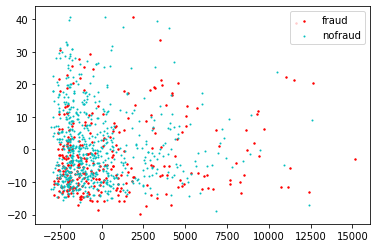

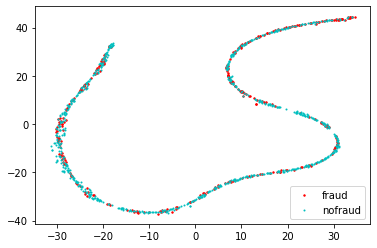

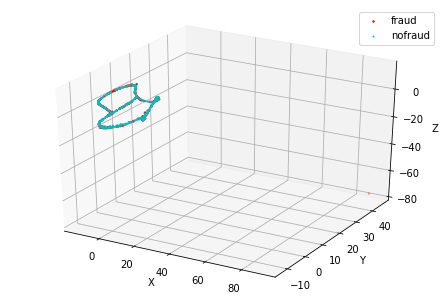

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
#对数据进行主成分分析，降维到2维空间。
non_fraud = data[data['default'] == 0]
fraud = data[data['default'] == 1]
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['default'], axis = 1).values
index1 = df[df.default==1].index
index0 = df[df.default==0].index
data_pca = PCA(n_components=2).fit_transform(X)
f = plt.figure(1)#观察数据分布
plt.scatter(data_pca[index1,0],data_pca[index1,1],marker = 'o', color = 'r',s=2,label='fraud')
plt.scatter(data_pca[index0,0],data_pca[index0,1],marker = 'o', color = 'c',s=1,label='nofraud')
plt.legend()
plt.show()

#尝试用T-SNE降维，优势：非线性
data_tsne = TSNE(n_components=2).fit_transform(X)
f = plt.figure(1)#观察数据分布
plt.scatter(data_tsne[index1,0],data_tsne[index1,1],marker = 'o', color = 'r',s=2,label='fraud')
plt.scatter(data_tsne[index0,0],data_tsne[index0,1],marker = 'o', color = 'c',s=1,label='nofraud')
plt.legend()
plt.show()

#进行3D可视化
data_tsne = TSNE(n_components=3).fit_transform(X)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data_tsne[index1,0],data_tsne[index1,1],data_tsne[index1,2], marker = 'o', color = 'r',s=2, label='fraud')  # 绘制数据点
ax.scatter(data_tsne[index0,0],data_tsne[index0,1],data_tsne[index0,2], marker = 'o', color = 'c',s=1, label='nofraud')
ax.set_zlabel('Z')  # 坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.legend()
plt.show()

(1000, 590)
(1000,)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	training's auc: 0.804581	valid_1's auc: 0.778426
Fold 1 | AUC: 0.7784256559766765
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's auc: 0.808947	valid_1's auc: 0.752308
Fold 2 | AUC: 0.7523080660835763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	training's auc: 0.822249	valid_1's auc: 0.761419
Fold 3 | AUC: 0.761418853255588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	training's auc: 0.830995	valid_1's auc: 0.688533
Fold 4 | AUC: 0.6885325558794947
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.846225	valid_1's auc: 0.813654
Early stopping, best iteration is:
[336]	training's auc: 0.868243	valid_1's auc: 0.825559
Fold 5 | AUC: 0.82555879494655

Mean AUC = 

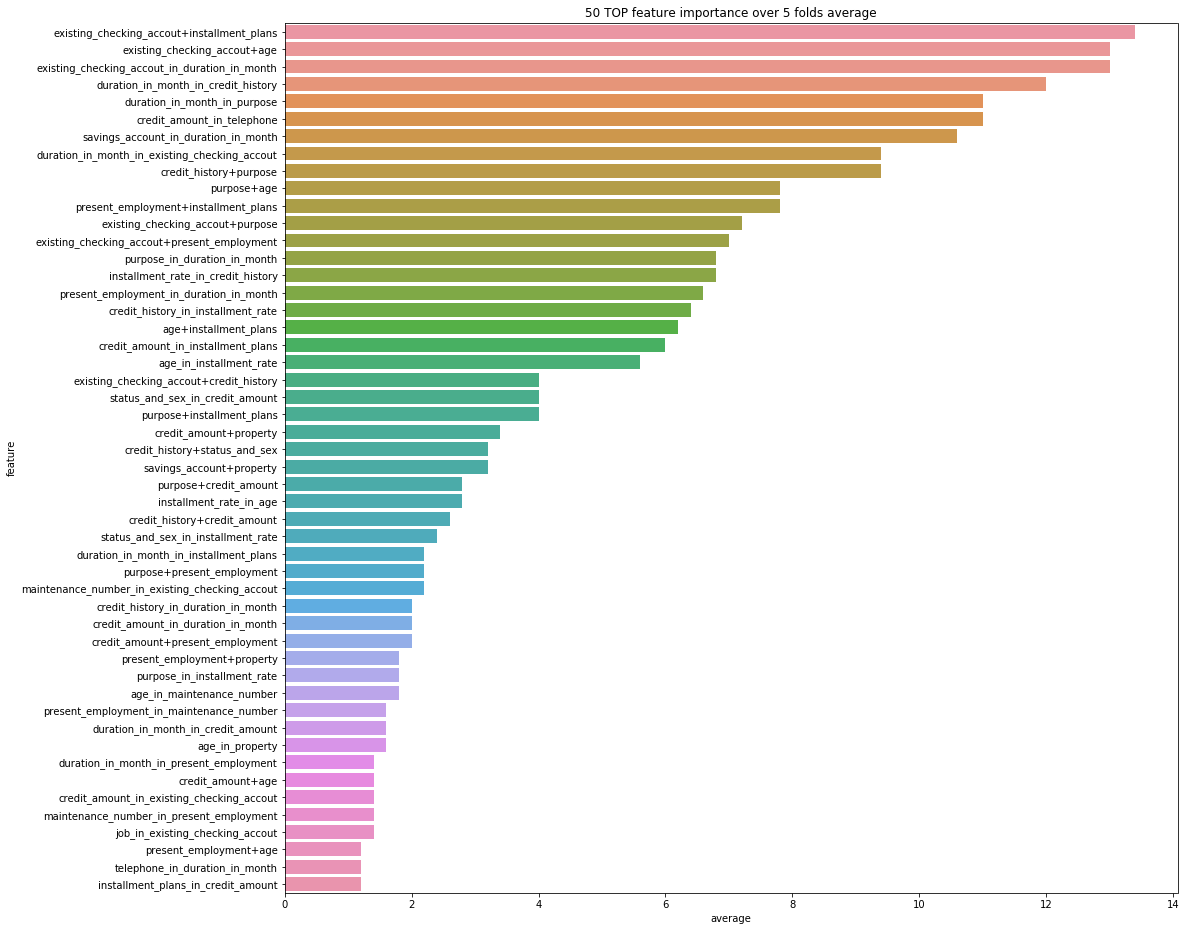

In [30]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
sd = StandardScaler()
data1 = pd.read_csv('data1.csv')
X = data1.iloc[:,:-1]
y = data1.iloc[:,-1]
print(X.shape)
print(y.shape)
column=X.columns
X[column]=sd.fit_transform(X[column])
X,X_test,y,y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# lgb
params={'num_leaves':128,
        'min_child_weight': 0.03,
        'feature_fraction': 0.4,
        'bagging_fraction': 0.4,
        'min_data_in_leaf': 106,
        'objective': 'binary',
        'max_depth': 5,
        'learning_rate': 0.006,
        "boosting_type": "gbdt",
        "bagging_seed": 11,
        "metric": 'auc',
        "verbosity": -1,
        'reg_alpha': 0.4,
        'reg_lambda': 0.6,
        'random_state': 47,
        }
NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS,random_state=123)
columns = X.columns
splits = folds.split(X, y)
y_oof = np.zeros(X.shape[0])
y_preds = np.zeros(X_test.shape[0])
score = 0
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]   
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=50)   
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()   
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    del X_train, X_valid, y_train, y_valid
    gc.collect()
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")
print(f"test datasets AUC = {roc_auc_score(y_test, y_preds)}")
print(f"test datasets Precision = {precision_score(y_test, np.around(y_preds))}")
print(f"test datasets Recall = {recall_score(y_test, np.around(y_preds))}")
print(f"test datasets F1 = {f1_score(y_test, np.around(y_preds))}")
print(f"test datasets Accuracy = {accuracy_score(y_test, np.around(y_preds))}")
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(5)]].mean(axis=1)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits))
plt.show()

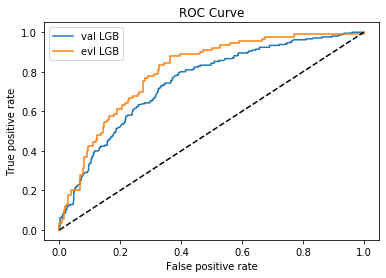

val_ks :  0.5158730158730158


In [39]:
fpr_train, tpr_train, thresholds = roc_curve(y, y_oof)
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.plot(fpr_train,tpr_train,label='val LGB')
plt.plot(fpr,tpr,label='evl LGB')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

val_ks = (tpr-fpr).max()
print('val_ks : ', val_ks)

In [46]:
for i in range(100):
    pred_label = y_oof > i/100
    print("threshod",i/100)
    print(f"Precision = {precision_score(y, pred_label)}")
    print(f"Recall = {recall_score(y, pred_label)}")
    print(f"F1 = {f1_score(y, pred_label)}")
    print(f"Accuracy = {accuracy_score(y, pred_label)}")

# threshod 0.3
# Precision = 0.4797297297297297
# Recall = 0.6761904761904762
# F1 = 0.5612648221343874
# Accuracy = 0.6828571428571428

threshod 0.0
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.01
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.02
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.03
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.04
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.05
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.06
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.07
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.08
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.09
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.1
Precision = 0.3008595988538682
Recall = 1.0
F1 = 0.46255506607929514
Accuracy = 0.3028571428571429
threshod 0.11
Precision = 0.3012912482065997
Recall = 1.0
F1 = 0.4630

In [47]:
for i in range(100):
    pred_label = y_preds > i/100
    print("threshod",i/100)
    print(f"Precision = {precision_score(y_test, pred_label)}")
    print(f"Recall = {recall_score(y_test, pred_label)}")
    print(f"F1 = {f1_score(y_test, pred_label)}")
    print(f"Accuracy = {accuracy_score(y_test, pred_label)}")
# 根据验证集选择使f1最大的阈值0.3，以下为测试集表现
# threshod 0.3
# Precision = 0.5343511450381679
# Recall = 0.7777777777777778
# F1 = 0.6334841628959276
# Accuracy = 0.73

threshod 0.0
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.01
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.02
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.03
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.04
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.05
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.06
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.07
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.08
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.09
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.1
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.11
Precision = 0.3
Recall = 1.0
F1 = 0.4615384615384615
Accuracy = 0.3
threshod 0.12
Prec

In [48]:
NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS,random_state=123)
columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    clf = LogisticRegression(random_state=123,n_jobs=2)
    clf.fit(X_train,y_train)
    
    y_pred_valid = clf.predict_proba(X_valid)[:,1]
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict_proba(X_test)[:,1] / NFOLDS
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")
print(f"test datasets AUC = {roc_auc_score(y_test, y_preds)}")

Fold 1 | AUC: 0.7142857142857142
Fold 2 | AUC: 0.7254616132167153
Fold 3 | AUC: 0.7099125364431487
Fold 4 | AUC: 0.6802721088435374
Fold 5 | AUC: 0.7558309037900874

Mean AUC = 0.7171525753158406
Out of folds AUC = 0.7168804664723032
test datasets AUC = 0.73994708994709


In [49]:
pred_label = y_preds > 0.3
print(f"Precision = {precision_score(y_test, pred_label)}")
print(f"Recall = {recall_score(y_test, pred_label)}")
print(f"F1 = {f1_score(y_test, pred_label)}")
print(f"Accuracy = {accuracy_score(y_test, pred_label)}")

pred_label = y_preds > 0.5
print(f"Precision = {precision_score(y_test, pred_label)}")
print(f"Recall = {recall_score(y_test, pred_label)}")
print(f"F1 = {f1_score(y_test, pred_label)}")
print(f"Accuracy = {accuracy_score(y_test, pred_label)}")

Precision = 0.47244094488188976
Recall = 0.6666666666666666
F1 = 0.5529953917050692
Accuracy = 0.6766666666666666
Precision = 0.5494505494505495
Recall = 0.5555555555555556
F1 = 0.5524861878453039
Accuracy = 0.73


In [65]:
from sklearn.decomposition import PCA
pca = PCA()

sd = StandardScaler()
data1 = pd.read_csv('data1.csv')
X = data1.iloc[:,:-1]
y = data1.iloc[:,-1]
print(X.shape)
print(y.shape)
column=X.columns
X[column]=sd.fit_transform(X[column])
X,X_test,y,y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

X = pca.fit_transform(X)
X_test = pca.transform(X_test)
print(X.shape)
print(X_test.shape)

(1000, 590)
(1000,)
(700, 590)
(300, 590)


In [66]:
NFOLDS = 5
X = pd.DataFrame(X)
X_test = pd.DataFrame(X_test)
folds = StratifiedKFold(n_splits=NFOLDS,random_state=123)
columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    clf = LogisticRegression(random_state=123,n_jobs=2)
    clf.fit(X_train,y_train)
    
    y_pred_valid = clf.predict_proba(X_valid)[:,1]
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict_proba(X_test)[:,1] / NFOLDS
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")
print(f"test datasets AUC = {roc_auc_score(y_test, y_preds)}")

Fold 1 | AUC: 0.7137998056365404
Fold 2 | AUC: 0.7259475218658892
Fold 3 | AUC: 0.7101554907677357
Fold 4 | AUC: 0.6805150631681244
Fold 5 | AUC: 0.7563168124392614

Mean AUC = 0.7173469387755103
Out of folds AUC = 0.7168901846452866
test datasets AUC = 0.7397354497354498


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	training's auc: 0.81767	valid_1's auc: 0.79689
Fold 1 | AUC: 0.7968901846452866
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's auc: 0.860165	valid_1's auc: 0.750972
Fold 2 | AUC: 0.7509718172983478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	training's auc: 0.874757	valid_1's auc: 0.70068
Fold 3 | AUC: 0.7006802721088435
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's auc: 0.859322	valid_1's auc: 0.708941
Fold 4 | AUC: 0.7089407191448007
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	training's auc: 0.883185	valid_1's auc: 0.789602
Fold 5 | AUC: 0.7896015549076774

Mean AUC = 0.7494169096209913
Out of folds AUC = 0.7371331389698736
test datasets AUC =

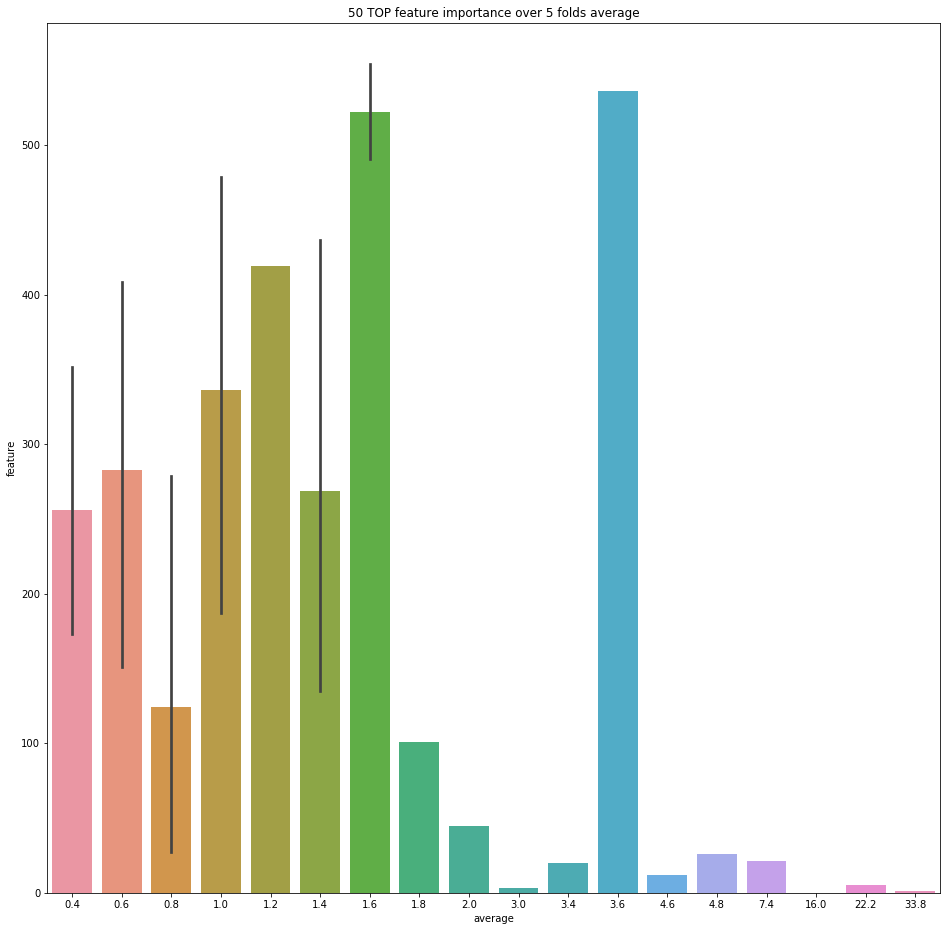

In [67]:
NFOLDS = 5
X = pd.DataFrame(X)
X_test = pd.DataFrame(X_test)
folds = StratifiedKFold(n_splits=NFOLDS,random_state=123)
columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]   
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=50)   
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()   
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    del X_train, X_valid, y_train, y_valid
    gc.collect()
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")
print(f"test datasets AUC = {roc_auc_score(y_test, y_preds)}")
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(5)]].mean(axis=1)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits))
plt.show()